In [1]:
from DiabetesModels import *

# Parameters for simulation
environment = read_env(ndim=2)

# Setup simulation from env dict
simulation = Simulation(environment._asdict())
# Get idea of paars to change
environment

# Turn notebook into script
# !jupyter nbconvert --to script config_template.ipynb


env(path='debug/', maxPatient=1000, patientNr=667, path_to_simulations='simulations/', nMeals=200, ndim=2, loss_fun='CGP', jupyter=True, hypoglycemia=5, target=5, patient_filter=True)

In [2]:
!jupyter nbconvert --to script run_rls_2d.ipynb
!mv run_rls_2d.py simulations/

[NbConvertApp] Converting notebook run_rls_2d.ipynb to script
[NbConvertApp] Writing 2327 bytes to run_rls_2d.py


In [2]:
# Change parameters of simulation here if you want to
# look above!
# simulation.par = xxx
# simulation.patientNr = 778
simulation.loss_fun = 'CGP'
simulation.nMeals = 200
simulation.patient_filter = True
simulation.target = 5.0
simulation.hypoglycemia = 5.0
#simulation.hypoglycemia = 4.2
## Initiate simulation for patient

# print environment for debugging purposes
simulation_tuple = namedtuple('debug_tuple', simulation.__dict__)
print(simulation_tuple(**simulation.__dict__))

debug_tuple(path='debug/', maxPatient=1000, patientNr=778, path_to_simulations='simulations/', nMeals=100, ndim=2, loss_fun='CGP', jupyter=True, hypoglycemia=5.0, target=5.0, patient_filter=True)


In [3]:
### Init patient
simulation.init_patient()

In [4]:
# Bolus fun for RLS
def bolus_fun(Meal, simulation):
    patient = simulation.patient
    ndim = simulation.ndim

    # Parameters of algorithm
    beta = 0.95
    lam = 0.05

    xx = np.array([Meal.squeeze(), 0]).reshape((ndim,1)) # no distortion
    # Try except to initiate
    try:
        # 
        e = (patient.CGM[-1] - simulation.target) * patient.ISF
        z = patient.P @ xx
        k = z / (beta + np.transpose(xx) @ z)
        patient.theta = patient.theta + k * e
        patient.P = patient.P/beta + k @ np.diag(k * z) /beta

    except AttributeError: # There is no P - initiate algorithm
        patient.P = 1/lam * np.eye(ndim)
        m = 1/patient.ICR
        patient.theta = np.array([m, 0]).reshape((ndim, 1))

    Bolus = np.transpose(patient.theta) @ xx
    return Bolus

In [5]:
### Do simulation
simulation.simulate(simulation.simulate_meals, bolus_fun = bolus_fun)

Simulating for PatientNr: 797: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


No handles with labels found to put in legend.


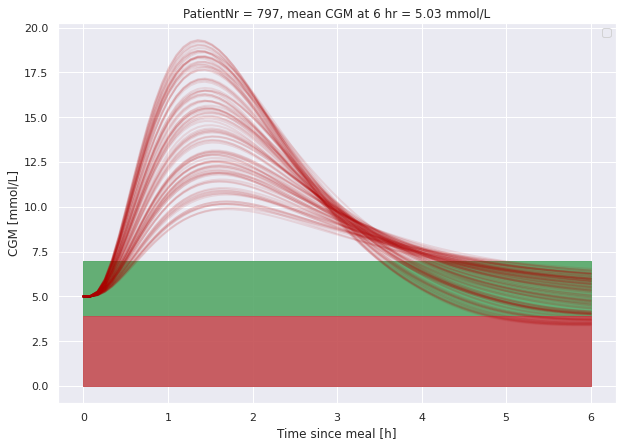

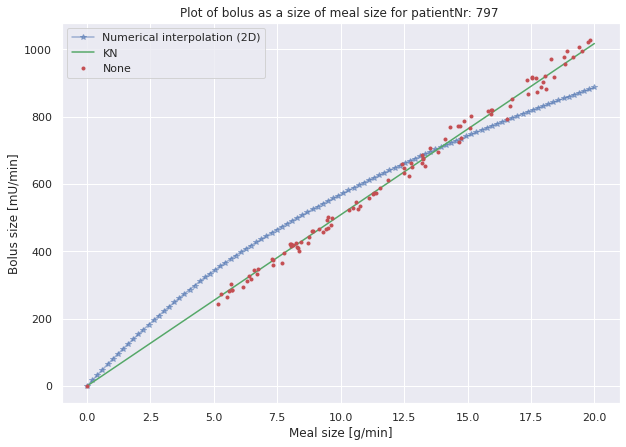

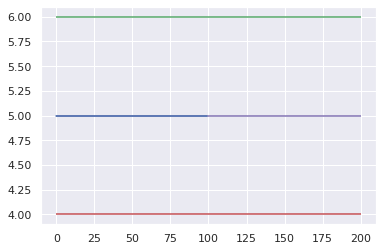

5.0 64.33333333333333 2.3472222222222223


In [6]:
if simulation.jupyter:
    simulation.patient.set_u_opt()
    simulation.plot_CGM()
    simulation.make_u_opt_plot()

    plt.figure()
    plt.plot(simulation.nBG0)
    plt.hlines(6,0,200,'g')
    plt.hlines(5,0,200,'m')
    plt.hlines(4,0,200,'r')
    plt.show()

    print(simulation.nBG0.mean(),simulation.nTIR.mean(), simulation.nTBR.mean())

    